# Predição de Série Temporal com RNN
Esse notebook tem como objetivo prever a volatilidade das ações da NVIDIA usando Redes Neurais Recorrentes (RNN).
Utilizando o dataset [NVIDIA Stock Volatility (2014-2024)](https://www.kaggle.com/datasets/avinashmynampati/nvidia-stock-volatility-20142024) disponível no Kaggle.

In [ ]:
# importação de bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

## Carregamento e limpeza de dados

In [2]:
df = pd.read_csv('NVIDIA_Stock_Volatility_2014_2024.csv')
df.head()

,Date,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
0,2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
1,2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2,2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
3,2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
4,2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


O *dataset* contém dados diários das ações da NVIDIA, incluindo preço de abertura, fechamento, máximos e mínimos, volume negociado, retornos diários, volatilidade móvel, média móvel e indicadores técnicos como *Bollinger Bands* (superior e inferior) ajudam a identificar tendências, enquanto *ATR* mede a volatilidade do ativo.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2541 non-null   object 
 1   Close               2541 non-null   float64
 2   High                2541 non-null   float64
 3   Low                 2541 non-null   float64
 4   Open                2541 non-null   float64
 5   Volume              2541 non-null   int64  
 6   Daily_Return        2541 non-null   float64
 7   Rolling_Volatility  2541 non-null   float64
 8   ATR                 2541 non-null   float64
 9   Rolling_Mean        2541 non-null   float64
 10  Upper_Band          2541 non-null   float64
 11  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 238.3+ KB


In [4]:
# converter 'Date' em data e hora e definir como índice
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
Date,,,,,,,,,,,
2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


In [5]:
# verificar se há valores ausentes
print(df.isnull().sum())

Close                 0
High                  0
Low                   0
Open                  0
Volume                0
Daily_Return          0
Rolling_Volatility    0
ATR                   0
Rolling_Mean          0
Upper_Band            0
Lower_Band            0
dtype: int64


In [6]:
# verificar se há duplicatas
df.duplicated().sum()

np.int64(0)

In [7]:
# garantir que os dados sejam classificados por data
df = df.sort_index()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2541 entries, 2014-01-31 to 2024-03-06
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               2541 non-null   float64
 1   High                2541 non-null   float64
 2   Low                 2541 non-null   float64
 3   Open                2541 non-null   float64
 4   Volume              2541 non-null   int64  
 5   Daily_Return        2541 non-null   float64
 6   Rolling_Volatility  2541 non-null   float64
 7   ATR                 2541 non-null   float64
 8   Rolling_Mean        2541 non-null   float64
 9   Upper_Band          2541 non-null   float64
 10  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 238.2 KB


## Construção do modelo de predição com RNN

In [9]:
# seleção de features e normalização
features = ["Close", "Rolling_Mean", "Upper_Band", "Lower_Band"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) # prevendo apenas o "Close"
    return np.array(X), np.array(y)

seq_length = 10 # janela de tempo de 10 dias
X, y = create_sequences(df[features].values, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Uma RNN com 50 neurônios na camada oculta e ativação ReLU é utilizada. A saída consiste em uma camada densa com um único neurônio para prever o fechamento da ação. O MSE é escolhido por ser adequado a problemas de regressão, pois mede a média dos erros ao quadrado, enfatizando desvios maiores. Isso é essencial para prever preços de ações, onde erros elevados podem indicar instabilidade no modelo.

In [10]:
model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(seq_length, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

## Treinamento do modelo

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2732e-05 - val_loss: 0.0013
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7981e-05 - val_loss: 8.0132e-04
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9196e-05 - val_loss: 7.3580e-04
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1432e-05 - val_loss: 6.3307e-04
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6973e-05 - val_loss: 9.0357e-04
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5491e-05 - val_loss: 0.0018
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7694e-05 - val_loss: 6.2897e-04
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4218e-05 - val_loss: 4.2063e-04
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9286e-05 - val_loss: 4.1566e-04
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1567e-05 - 

## Avaliação e Previsão

In [12]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], len(features) - 1)))))[:, 0]
y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1)))))[:, 0]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


## Apresentação dos resultados

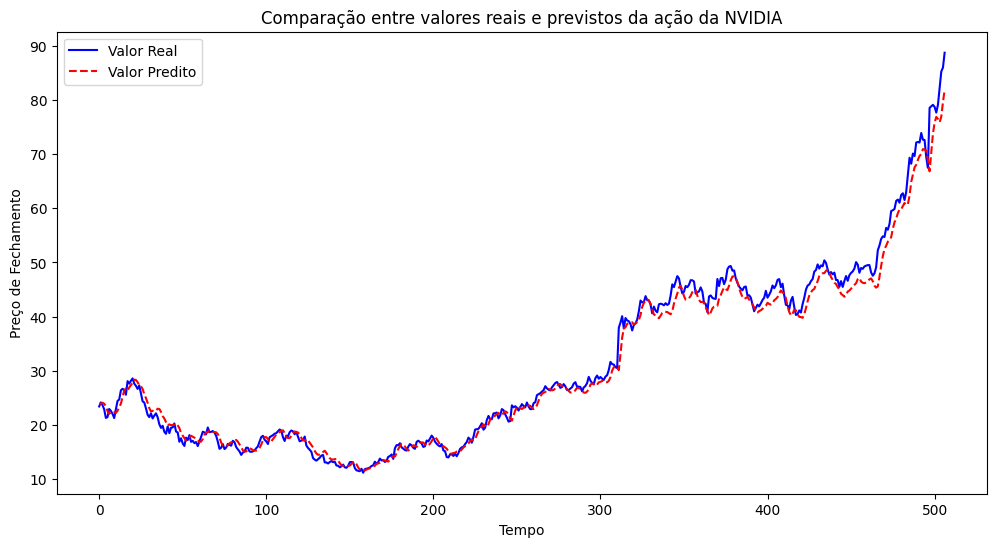

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valor Real', color='blue')
plt.plot(y_pred, label='Valor Predito', linestyle='dashed', color='red')
plt.xlabel("Tempo")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.title("Comparação entre valores reais e previstos da ação da NVIDIA")
plt.show()

O valor final do MSE no conjunto de teste foi baixo, indicando boa precisão na previsão dos preços de fechamento da ação. O gráfico mostra que os valores previstos acompanham bem a tendência dos valores reais.